## Argo Multiple Regions Test

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import argopy
#from argopy import DataFetcher as ArgoDataFetcher
#argo_loader = ArgoDataFetcher(parallel=True)
import scipy.ndimage as filter
filter.gaussian_filter1d
import cartopy.crs as ccrs
import cartopy

## Useful Functions

In [53]:
#NOTE: choosing higer depth_max values will limit the number of profiles returned
def get_ds_interp(ds,depth_min,depth_max,sample_max):
    median_dp=ds.PRES.where(ds.PRES<depth_max).where(ds.PRES>depth_min).diff('N_LEVELS').median('N_LEVELS')
    ind_rate=median_dp.where(median_dp<sample_max,drop=True).N_PROF
    ds_sel=ds.sel(N_PROF=ind_rate)
    ds_interp=ds_sel.argo.interp_std_levels(np.arange(depth_min,depth_max,2))
    ds_interp=ds_interp.sortby(ds_interp.N_PROF)
    return ds_interp.TEMP

In [54]:
def get_ds_filt(ds_interp,first,last,num):
    sigmas=np.logspace(first,last,num)
    temp=np.zeros((ds_interp.N_PROF.shape[0],ds_interp.PRES_INTERPOLATED.shape[0],num))

    for n in range(0,num):
        temp[:,:,n]=filter.gaussian_filter1d(ds_interp,sigma=sigmas[n],mode='nearest')

    ds_filt=xr.DataArray(temp,dims=['N_PROF','PRES_INTERPOLATED','FILT_SCALE'],
             coords={'N_PROF':ds_interp.N_PROF,'PRES_INTERPOLATED':ds_interp.PRES_INTERPOLATED,'FILT_SCALE':sigmas})
    return ds_filt

In [55]:
def get_var(ds_interp,ds_filt):
    var=np.zeros(len(ds_filt.FILT_SCALE))
    for n,sig in enumerate(so_filt.FILT_SCALE):
        prof=ds_filt.sel(FILT_SCALE=sig)
        var[n]=(prof-ds_interp).var()
    return var

In [56]:
def get_2_depths(ds,first,mid,last,sample_max):
    interp_1=get_ds_interp(ds,first,mid,sample_max)
    interp_2=get_ds_interp(ds,mid,last,sample_max)
    
    filt_1=get_ds_filt(interp_1,0.5,2.5,50)
    filt_2=get_ds_filt(interp_2,0.5,2.5,50)
    
    var_1=get_var(interp_1,filt_1)
    var_2=get_var(interp_2,filt_2)
    
    return filt_1,var_1,filt_2,var_2

In [57]:
def get_3_depths(ds,first,mid1,mid2,last,sample_max):
    interp_1=get_ds_interp(ds,first,mid1,sample_max)
    interp_2=get_ds_interp(ds,mid1,mid2,sample_max)
    interp_3=get_ds_interp(ds,mid2,last,sample_max)
    
    filt_1=get_ds_filt(interp_1,0.5,2.5,50)
    filt_2=get_ds_filt(interp_2,0.5,2.5,50)
    filt_3=get_ds_filt(interp_3,0.5,2.5,50)
    
    var_1=get_var(interp_1,filt_1)
    var_2=get_var(interp_2,filt_2)
    var_3=get_var(interp_3,filt_3)
    
    return filt_1,var_1,filt_2,var_2,filt_3,var_3

## Define Regions

In [50]:
#Southern Ocean, south of Africa
so_param=[30,40,-55,-50,0,2000]
so_ds=xr.open_dataset("202206_lon:(30,40)_lat:(-55,-50).nc")

In [4]:
#North Pacific
np_param=[-155,-145,35,40,0,2000]
np_ds=xr.open_dataset("")

In [5]:
#North Atlantic
na_param=[-35,-25,40,45,0,2000]
na_ds=xr.open_dataset("")

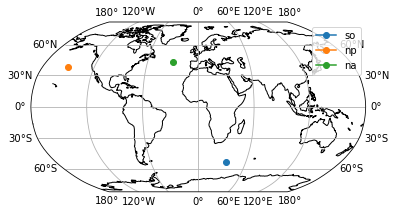

In [22]:
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.plot(np.average(so_param[0:2]), np.average(so_param[2:4]), marker='o',transform=ccrs.PlateCarree(),label='so')
plt.plot(np.average(np_param[0:2]), np.average(np_param[2:4]), marker='o',transform=ccrs.PlateCarree(),label='np')
plt.plot(np.average(na_param[0:2]), np.average(na_param[2:4]), marker='o',transform=ccrs.PlateCarree(),label='na')
plt.legend()

In [58]:
so_interp=get_ds_interp(so_ds,0,2000,3)
#np_interp=get_ds_interp(np_ds,0,2000,3)
#na_interp=get_ds_interp(na_ds,0,2000,3)

In [60]:
so_filt=get_ds_filt(so_interp,0.5,2.5,50)
#np_filt=get_ds_filt(np_interp,0.5,2.5,50)
#na_filt=get_ds_filt(na_interp,0.5,2.5,50)

In [61]:
so_var=get_var(so_interp,so_filt)
#np_var=get_var(np_interp,np_filt)
#na_var=get_var(na_interp,na_filt)

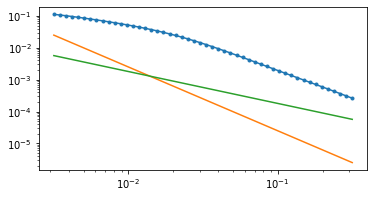

In [63]:
plt.figure(figsize=(20,3))

plt.subplot(1,3,1)
plt.plot(1/so_filt.FILT_SCALE,so_var,'.-')
plt.xscale('log')
plt.yscale('log')
x=1/so_filt.FILT_SCALE
y_2=2.5*10**-7*x**-2
y_1=1.8*10**-5*x**-1
plt.plot(x,y_2)
plt.plot(x,y_1)

# plt.subplot(1,3,2)
# plt.plot(1/np_filt.FILT_SCALE,np_var,'.-')
# plt.xscale('log')
# plt.yscale('log')
# x=1/np_filt.FILT_SCALE
# y_2=2.5*10**-7*x**-2
# y_1=1.8*10**-5*x**-1
# plt.plot(x,y_2)
# plt.plot(x,y_1)

# plt.subplot(1,3,3)
# plt.plot(1/na_filt.FILT_SCALE,na_var,'.-')
# plt.xscale('log')
# plt.yscale('log')
# x=1/na_filt.FILT_SCALE
# y_2=2.5*10**-7*x**-2
# y_1=1.8*10**-5*x**-1
# plt.plot(x,y_2)
# plt.plot(x,y_1)

## Filtering at Different Depths

Text(0.5, 1.0, 'Southern Ocean')

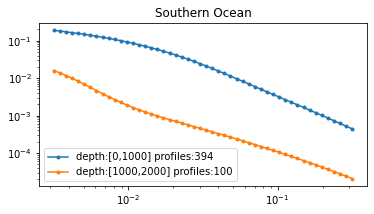

In [67]:
plt.figure(figsize=(20,3))

first,mid,last,sample_max=0,1000,2000,3

plt.subplot(1,3,1)
so_filt_1,so_var_1,so_filt_2,so_var_2=get_2_depths(so_ds,first,mid,last,sample_max)
plt.plot(1/so_filt_1.FILT_SCALE,so_var_1,'.-',label='depth:[{},{}] profiles:{}'.format(first,mid,so_filt_1.N_PROF.shape[0]))
plt.plot(1/so_filt_2.FILT_SCALE,so_var_2,'.-',label='depth:[{},{}] profiles:{}'.format(mid,last,so_filt_2.N_PROF.shape[0]))
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title("Southern Ocean")

# plt.subplot(1,3,2)
# np_filt_1,np_var_1,np_filt_2,np_var_2=get_2_depths(np_ds,0,1000,2000,3)
# plt.plot(1/np_filt_1.FILT_SCALE,np_var_1,'.-',label='depth:[{},{}] profiles:{}'.format(first,mid,np_filt_1.N_PROF.shape[0]))
# plt.plot(1/np_filt_2.FILT_SCALE,np_var_2,'.-',label='depth:[{},{}] profiles:{}'.format(mid,last,np_filt_2.N_PROF.shape[0]))
# plt.xscale('log')
# plt.yscale('log')
# plt.legend()
# plt.title("North Pacific")


# plt.subplot(1,3,3)
# np_filt_1,np_var_1,np_filt_2,np_var_2=get_2_depths(np_ds,0,1000,2000,3)
# plt.plot(1/na_filt_1.FILT_SCALE,na_var_1,'.-',label='depth:[{},{}] profiles:{}'.format(first,mid,na_filt_1.N_PROF.shape[0]))
# plt.plot(1/na_filt_2.FILT_SCALE,na_var_2,'.-',label='depth:[{},{}] profiles:{}'.format(mid,last,na_filt_2.N_PROF.shape[0]))
# plt.xscale('log')
# plt.yscale('log')
# plt.legend()
# plt.title("North Atlantic")

Text(0.5, 1.0, 'Southern Ocean')

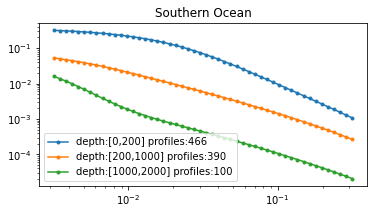

In [69]:
plt.figure(figsize=(20,3))

first,mid1,mid2,last,sample_max=0,200,1000,2000,3

plt.subplot(1,3,1)
so_filt_1,so_var_1,so_filt_2,so_var_2,so_filt_3,so_var_3=get_3_depths(so_ds,first,mid1,mid2,last,sample_max)
plt.plot(1/so_filt_1.FILT_SCALE,so_var_1,'.-',label='depth:[{},{}] profiles:{}'.format(first,mid1,so_filt_1.N_PROF.shape[0]))
plt.plot(1/so_filt_2.FILT_SCALE,so_var_2,'.-',label='depth:[{},{}] profiles:{}'.format(mid1,mid2,so_filt_2.N_PROF.shape[0]))
plt.plot(1/so_filt_3.FILT_SCALE,so_var_3,'.-',label='depth:[{},{}] profiles:{}'.format(mid2,last,so_filt_3.N_PROF.shape[0]))
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title("Southern Ocean")

# plt.subplot(1,3,1)
# np_filt_1,np_var_1,np_filt_2,np_var_2,np_filt_3,np_var_3=get_3_depths(np_ds,first,mid1,mid2,last,sample_max)
# plt.plot(1/np_filt_1.FILT_SCALE,np_var_1,'.-',label='depth:[{},{}] profiles:{}'.format(first,mid1,np_filt_1.N_PROF.shape[0]))
# plt.plot(1/np_filt_2.FILT_SCALE,np_var_2,'.-',label='depth:[{},{}] profiles:{}'.format(mid1,mid2,np_filt_2.N_PROF.shape[0]))
# plt.plot(1/np_filt_3.FILT_SCALE,np_var_3,'.-',label='depth:[{},{}] profiles:{}'.format(mid2,last,np_filt_3.N_PROF.shape[0]))
# plt.xscale('log')
# plt.yscale('log')
# plt.legend()
# plt.title("Southern Ocean")


# plt.subplot(1,3,1)
# na_filt_1,na_var_1,na_filt_2,na_var_2,na_filt_3,na_var_3=get_3_depths(na_ds,first,mid1,mid2,last,sample_max)
# plt.plot(1/na_filt_1.FILT_SCALE,na_var_1,'.-',label='depth:[{},{}] profiles:{}'.format(first,mid1,na_filt_1.N_PROF.shape[0]))
# plt.plot(1/na_filt_2.FILT_SCALE,na_var_2,'.-',label='depth:[{},{}] profiles:{}'.format(mid1,mid2,na_filt_2.N_PROF.shape[0]))
# plt.plot(1/na_filt_3.FILT_SCALE,na_var_3,'.-',label='depth:[{},{}] profiles:{}'.format(mid2,last,na_filt_3.N_PROF.shape[0]))
# plt.xscale('log')
# plt.yscale('log')
# plt.legend()
# plt.title("Southern Ocean")